# Multi-task PCA - repeats

I'm going to continue from the last experiment but running repeats to have a stronger idea of distribution.

In [1]:
import torch
from torch import nn
from torch.optim import Adam
from matplotlib import pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np
import os
import random
from collections import OrderedDict
import pacmap

## Global utilities

### Misc

In [2]:
def generate_seed():
    return np.random.randint(1, 2**32 - 1)


def set_all_seeds(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

### Network

In [3]:
class LinearLayer(nn.Module):
    def __init__(self, in_feats, out_feats, use_act=True, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.linear = nn.Linear(in_feats, out_feats)
        if use_act:
            self.act = nn.ReLU()
        self.use_act = use_act

    def forward(self, x):
        x = self.linear(x)
        if self.use_act:
            x = self.act(x)
        return x


class Net(nn.Module):
    def __init__(
        self, input_dim=4, hidden_dim=16, output_dim=2, *args, **kwargs
    ) -> None:
        super().__init__(*args, **kwargs)
        self.layers = nn.Sequential(
            LinearLayer(input_dim, hidden_dim, use_act=True),
            LinearLayer(hidden_dim, hidden_dim, use_act=True),
            LinearLayer(hidden_dim, output_dim, use_act=False),
        )

    def forward(self, x):
        return self.layers(x)


def print_model_parameters(model):
    for name, param in model.named_parameters():
        print(name, "\n", param.data, "\n")

### Data

In [4]:
# Generate Y values
def generate_Y(n_samples):
    return torch.rand(n_samples)


# Generate X values based on Y
def generate_X(Y, eps):
    X = torch.empty(len(Y), 2)
    X[:, 0] = Y / (torch.rand(len(Y)) * (1 - eps) + eps)
    X[:, 1] = Y / X[:, 0]

    # Randomly swap x1 and x2
    mask = torch.rand(len(Y)) < 0.5
    swap_vals = X[:, 0][mask]
    X[:, 0][mask] = X[:, 1][mask]
    X[:, 1][mask] = swap_vals

    return X


def generate_data(n_samples=10000):
    # Epsilon value
    eps = 0.5

    # Initial generation
    Y1 = generate_Y(n_samples)
    X1 = generate_X(Y1, eps)

    # Ensure they are statistically independent by generating new Y and X values
    Y2 = generate_Y(n_samples)
    X2 = generate_X(Y2, eps)

    # Stack X1 and X2 to get the desired shape
    X = torch.cat((X1, X2), dim=1)

    # Stack Y1 and Y2 for the desired shape
    Y = torch.stack((Y1, Y2), dim=1)

    # Validate the relationship
    assert torch.allclose(X[:, 0] * X[:, 1], Y[:, 0])
    assert torch.allclose(X[:, 2] * X[:, 3], Y[:, 1])

    s_inds = np.random.permutation(range(X.shape[0]))  # shuffled indices

    X_train = X[s_inds[:8000]]
    Y_train = Y[s_inds[:8000]]
    X_valid = X[s_inds[8000:]]
    Y_valid = Y[s_inds[8000:]]

    return X_train, Y_train, X_valid, Y_valid


def plot_data_distribution(X, Y):
    _, ax = plt.subplots()

    ax.hist(X[:, 0], alpha=0.5, density=True, label="mass")
    ax.hist(X[:, 1], alpha=0.5, density=True, label="acceleration")
    ax.hist(Y, alpha=0.5, density=True, label="force")
    ax.legend()

### Analysis functions

In [5]:
def capture_intermediate_outputs(model, input_tensor):
    """
    Captures the intermediate outputs of a PyTorch model.

    Args:
        model: A PyTorch model.
        input_tensor: A PyTorch tensor of shape (batch_size, *).
    Returns:
        A dictionary mapping layer names to intermediate outputs.
    """
    intermediate_values = OrderedDict()

    def hook_fn(module, input, output, name):
        if isinstance(module, nn.Linear):
            weight = module.weight
            input_value = input[0]
            intermediate_output = input_value.matmul(weight.t())
            intermediate_values[f"{name}.weight"] = intermediate_output
            intermediate_values[f"{name}.bias"] = output
        else:
            intermediate_values[name] = output

    hooks = []
    for name, layer in model.named_modules():
        hook = layer.register_forward_hook(
            lambda module, input, output, name=name: hook_fn(
                module, input, output, name
            )
        )
        hooks.append(hook)

    with torch.inference_mode():
        _ = model(input_tensor)

    for hook in hooks:
        hook.remove()

    filtered_values = {
        k: t for k, t in intermediate_values.items() if len(k.split(".")) > 2
    }
    return filtered_values

### Training/evaluation

In [6]:
def train(repeats=100, seeds=None):
    if seeds is None:
        seeds = [generate_seed() for _ in range(repeats)]

    rows = []
    for seed in tqdm(seeds):
        set_all_seeds(seed)

        # ~~~~~~~~~~~~~~~~~~~~~~~~~~ DATA ~~~~~~~~~~~~~~~~~~~~~~~~~~

        X_train, Y_train, X_valid, Y_valid = generate_data(n_samples=10000)

        # ~~~~~~~~~~~~~~~~~~~~~~~~~~ TRAIN ~~~~~~~~~~~~~~~~~~~~~~~~~~

        n_epochs = 4000  # number of epochs

        model = Net(input_dim=4, hidden_dim=16, output_dim=2)
        loss_func = nn.MSELoss()
        optimiser = Adam(model.parameters(), lr=1e-2)

        for _ in range(n_epochs):
            # Training update
            model.train()
            model.zero_grad()
            Y_hat = model(X_train)
            loss = loss_func(Y_hat, Y_train)
            loss.backward()
            optimiser.step()

            # Validation set
            model.eval()
            Y_hat = model(X_valid)
            loss = loss_func(Y_hat, Y_valid)

        # ~~~~~~~~~~~~~~~~~~~~~~~~~~ EVALUATION ~~~~~~~~~~~~~~~~~~~~~~~~~~

        res = {}

        N = 5
        pairs = np.concatenate(
            np.stack(np.meshgrid(np.linspace(0, 1, N), np.linspace(0, 1, N))).T
        )
        pairs = pairs.repeat(2, axis=0).reshape(-1, 4)
        pairs = torch.as_tensor(pairs).float()
        outputs = capture_intermediate_outputs(model, pairs)

        res["valid_loss"] = get_valid_loss(model, loss_func, X_valid, Y_valid)
        res["outputs"] = outputs
        res["model"] = model.state_dict()
        res["seed"] = seed

        rows.append(res)

    df = pd.DataFrame(
        rows
    )  # this is ok to fit in memory because our networks are so tiny

    return df


def plot_loss(train_loss, valid_loss, ax=None):
    if ax is None:
        _, ax = plt.subplots()

    ax.plot(train_loss, label="train")
    ax.plot(valid_loss, label="valid")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.legend()


# need to avoid flattening here because we have multiple outputs
def get_preds(model, X_valid, Y_valid):
    model.eval()

    with torch.inference_mode():
        out = model(X_valid)

    y_preds = out.numpy()
    y_targs = Y_valid.numpy()

    return y_preds, y_targs


def get_valid_loss(model, loss_func, X_valid, Y_valid):
    model.eval()

    with torch.inference_mode():
        out = model(X_valid)

    return loss_func(out, Y_valid)


def plot_results(y_preds, y_targs, ax=None):
    if ax is None:
        _, ax = plt.subplots()

    ax.scatter(y_preds, y_targs, s=4, label="predictions")
    ax.plot(y_targs, y_targs, color="salmon", ls="--", lw=0.5, label="perfect accuracy")
    ax.set(xlabel="y_preds", ylabel="y_targs")
    ax.legend()
    ax.set_aspect("equal")


def plot_model_performance_summary(model, df, X_valid, Y_valid):
    _, axes = plt.subplots(1, 2, figsize=(8, 4))

    axes[0] = plot_loss(df["train_loss"], df["valid_loss"], ax=axes[0])

    y_preds, y_targs = get_preds(model, X_valid, Y_valid)
    plot_results(y_preds, y_targs, ax=axes[1])
    axes[1].set_title(
        f"Validation loss: {get_valid_loss(model, nn.MSELoss(), X_valid, Y_valid):.5f}"
    )

## Toy Data

We now have two parallel multiplication tasks. Each is identically distributed but independent from each other.

#### Task A data

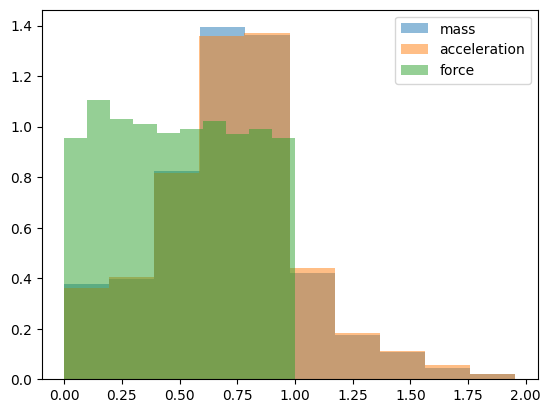

In [7]:
X_train, Y_train, X_valid, Y_valid = generate_data(n_samples=10000)

plot_data_distribution(X_train[:, :2], Y_train[:, 0])

#### Task B data

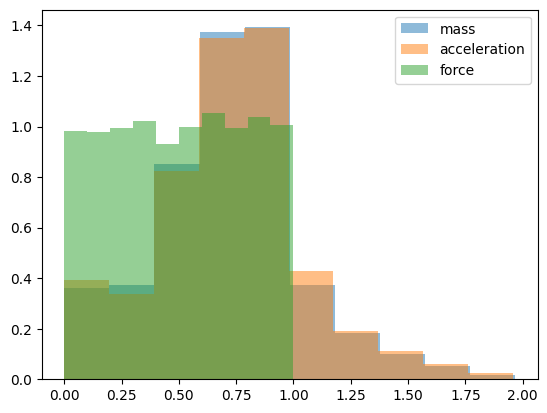

In [8]:
X_train, Y_train, X_valid, Y_valid = generate_data(n_samples=10000)

plot_data_distribution(X_train[:, 2:], Y_train[:, 1])

## Train repeats

In [9]:
seed = 3213569219
set_all_seeds(seed)
seeds = [generate_seed() for _ in range(100)]

df = train(seeds=seeds)

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
df["valid_loss"] = df["valid_loss"].apply(lambda x: x.item())

Just to check, we can see that all the networks have trained pretty well. Sufficient for our needs at least:

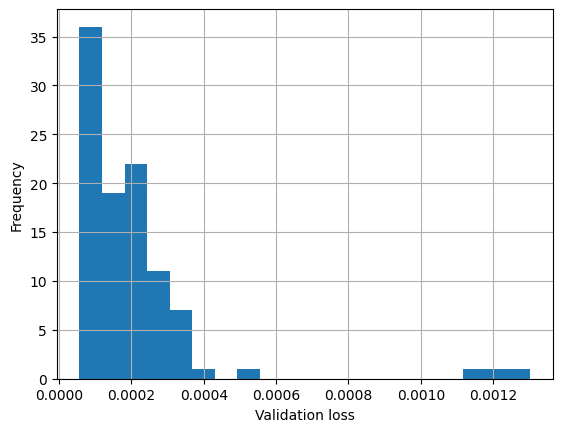

In [13]:
fig, ax = plt.subplots()
df.valid_loss.hist(ax=ax, bins=20)
_ = ax.set(xlabel="Validation loss", ylabel="Frequency")

In [16]:
# df.to_pickle("results/dfs/009.pkl")

## Experiments

### Multi-task activations PCA

#### Helper functions

In [14]:
def get_inputs(N=100, vary_task="A"):
    """Get inputs where one task is varied and the other is fixed."""
    pairs = np.concatenate(
        np.stack(np.meshgrid(np.linspace(0, 1, N), np.linspace(0, 1, N))).T
    )
    pairs = torch.tensor(pairs, dtype=torch.float32)
    if vary_task == "A":
        inputs = torch.cat((pairs, torch.full((len(pairs), 2), 0.5)), dim=1)
    if vary_task == "B":
        inputs = torch.cat((torch.full((len(pairs), 2), 0.5), pairs), dim=1)
    return inputs


def get_pcs(data):
    """Produce principal components and variances for a dataset."""
    mean = torch.mean(data, 0)
    data_centered = data - mean

    # Step 2: Compute the SVD
    U, S, V = torch.svd(data_centered)

    # The columns of V are the principal components
    principal_components = V

    # Step 3: Compute variances
    variances = S.pow(2) / (data.size(0) - 1)

    return principal_components, variances


def get_os(vectors):
    """Get orthogonality scores for a set of vectors."""
    angles = np.arctan2(vectors[..., 1], vectors[..., 0])
    os = np.abs(
        (np.mod(angles, np.pi / 2) - np.pi / 4) / (np.pi / 4)
    )  # I'm sure there's a neater way of doing this...
    return os

#### PCA analysis - combined tasks

First *not* separating out the task datasets for the PCA so we can see what the data looks like combined.

In [18]:
inputs = torch.cat((get_inputs(100, vary_task="A"), get_inputs(100, vary_task="B")))
inputs.shape

torch.Size([20000, 4])

In [ ]:
# ios = capture_intermediate_outputs(model, inputs)
# acts = ios["layers.0.act"]
# pcs, vs = get_pcs(acts)  # principal components and variances for both tasks at once
# cA = torch.matmul(pcs, acts[:10000].T).T  # task A mappings
# cB = torch.matmul(pcs, acts[10000:].T).T  # task B mappings
# cA.shape, cB.shape

#### PCA analysis - tasks separated

Now applying the PCA to the activations for each task-varying dataset separately.

In [45]:
rows = []
for i, row in tqdm(df.iterrows()):
    model = Net(input_dim=4, hidden_dim=16, output_dim=2)
    model.load_state_dict(row.model)
    model.eval()
    ios = capture_intermediate_outputs(model, inputs)
    acts = ios["layers.0.act"]
    pcs, _ = get_pcs(acts)  # principal components and variances for both tasks at once
    pcsA, _ = get_pcs(acts[:10000])  # principal components and variances for task A
    pcsB, _ = get_pcs(acts[10000:])  # principal components and variances for task B
    row["pcs"] = pcs
    row["pcsA"] = pcsA
    row["pcsB"] = pcsB
    row["acts"] = acts
    rows.append(row)
rdf = pd.DataFrame(rows)

0it [00:00, ?it/s]

In [98]:
# rdf.to_pickle("results/dfs/009-pca.pkl")

In [40]:
def get_sims(pcsA, pcsB):
    """Get the similarity matrix between two sets of principal components."""
    return torch.matmul(pcsA.T, pcsB).numpy()


def plot_similarity(sims, title="Dot-product Similarity of\nPrincipal Components"):
    fig, ax = plt.subplots(figsize=(6, 6))

    im = ax.imshow(sims, cmap="bwr", vmin=-1, vmax=1)
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=14)

    ax.set_title(title, fontsize=16)
    ax.set_xlabel("Task B", fontsize=14)
    ax.set_ylabel("Task A", fontsize=14)

In [36]:
sims = []
for i, row in rdf.iterrows():
    sim = get_sims(row.pcsA, row.pcsB)
    sims.append(sim)
sims = np.stack(sims)
sims.shape

(100, 16, 16)

Taking the absolute values here because here otherwise the structure is lost from cancellation:

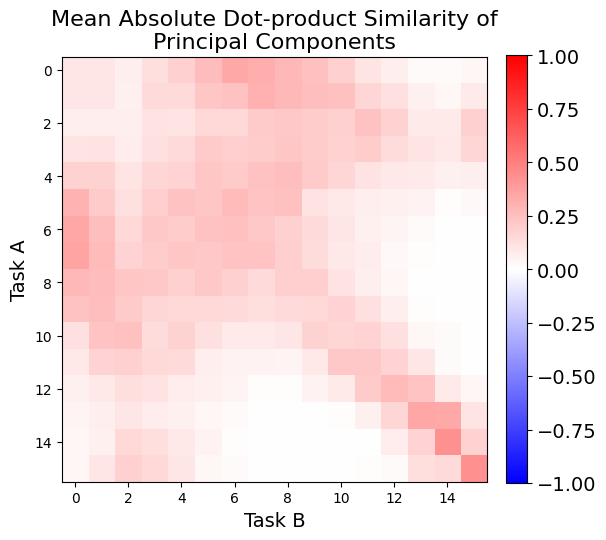

In [41]:
plot_similarity(
    np.abs(sims).mean(0),
    title="Mean Absolute Dot-product Similarity of\nPrincipal Components",
)

Nice structure that's formed here, I'd like to understand _more_ 🤔

Some points:
- the space is roughly symmetrical - as we'd expect for symmetrical tasks
- the top left is more orthogonal (lighter) - as we'd expect for independent tasks

Some questions:
- there's some diagonality here, especially at the lower variance components. I don't understand why the principal components for each task should be related in this way 🤷 I suppose this suggests that the lower variance components are more likely to be aligned between the tasks i.e. there are components in the space that are neglected by both tasks
- there are interesting clusters of non-orthogonality that I don't understand at
    - $(2,16)$ and $(16,2)$
    - $(0,6)$ and $(6,0)$
- there are larger clusters of orthogonality (patches of white on the edges) that I don't understand either

I suppose it would make sense to study the structure of this similarity matrix in response to changes in:
- hidden dimension
- task type i.e. try a different operation
- network depth

In [87]:
def compute_variances(pcs, acts, indices):
    return [torch.var((pcs[:, i] * acts[indices]).sum(-1)) for i in range(16)]


def compute_data_matrix(pcsA, pcsB, acts, return_separate=False):
    varAB = compute_variances(pcsA, acts, slice(10000, None))
    varAA = compute_variances(pcsA, acts, slice(0, 10000))
    varBA = compute_variances(pcsB, acts, slice(0, 10000))
    varBB = compute_variances(pcsB, acts, slice(10000, None))

    if return_separate:
        return varAB, varAA, varBA, varBB

    dataA = torch.stack((torch.stack(varAB), torch.stack(varAA))).T
    dataB = torch.stack((torch.stack(varBA), torch.stack(varBB))).T
    return dataA.numpy(), dataB.numpy()


mags, orthos, varsA, varsB = [], [], [], []

for _, row in rdf.iterrows():
    pcsA, pcsB, acts = row.pcsA, row.pcsB, row.acts
    dataA, dataB = compute_data_matrix(pcsA, pcsB, acts)
    data = np.concatenate([dataA, dataB])

    mag = np.linalg.norm(data, axis=1)
    ortho = get_os(data)

    mags.append(mag)
    orthos.append(ortho)
    varsA.append(dataA)
    varsB.append(dataB)


mags = np.concatenate(mags)
orthos = np.concatenate(orthos)

mags.shape, orthos.shape

((3200,), (3200,))

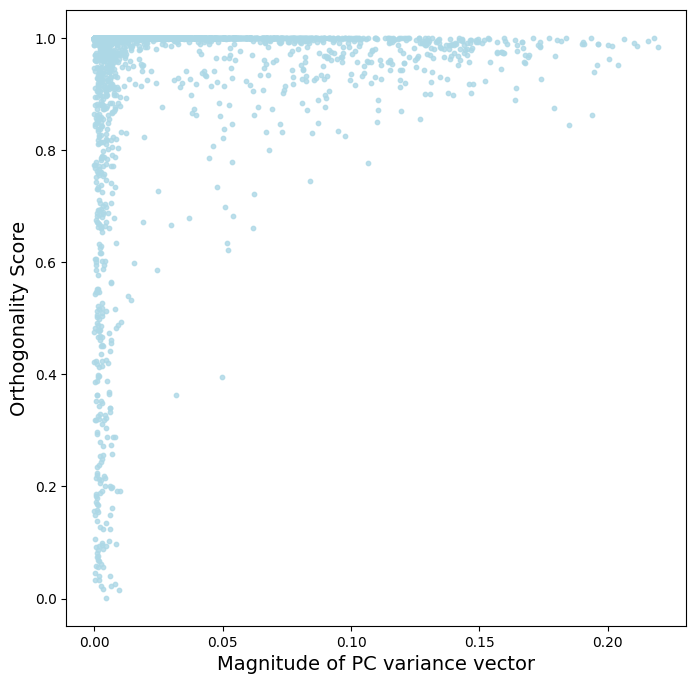

In [81]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.scatter(mags, orthos, color="lightblue", alpha=0.8, s=10)
ax.set_xlabel("Magnitude of PC variance vector", fontsize=14)
_ = ax.set_ylabel("Orthogonality Score", fontsize=14)

In [86]:
covs = []
for varA, varB in zip(varsA, varsB):
    covs.append(np.cov(varA.T))
    covs.append(np.cov(varB.T))
covs = np.stack(covs)

covs.mean(0)

array([[ 0.00049108, -0.00014327],
       [-0.00014327,  0.00151067]])

I'm not sure why there's asymmetry here but I suppose it's something I'm not understanding about covariance matrices because there's symmetry everywhere else 🤔

Alternatively, we can look at the variance explained:

In [94]:
varABs, varAAs, varBAs, varBBs = [], [], [], []
for _, row in rdf.iterrows():
    varAB, varAA, varBA, varBB = compute_data_matrix(
        row.pcsA, row.pcsB, row.acts, return_separate=True
    )
    varABs.append(varAB)
    varAAs.append(varAA)
    varBAs.append(varBA)
    varBBs.append(varBB)

varABs = np.stack(varABs)
varAAs = np.stack(varAAs)
varBAs = np.stack(varBAs)
varBBs = np.stack(varBBs)


def compute_mean_and_error(arr):
    mean = arr.mean(0)
    error = arr.std(0) / np.sqrt(len(arr))
    return mean, error


varAB, err_varAB = compute_mean_and_error(varABs)
varAA, err_varAA = compute_mean_and_error(varAAs)
varBA, err_varBA = compute_mean_and_error(varBAs)
varBB, err_varBB = compute_mean_and_error(varBBs)

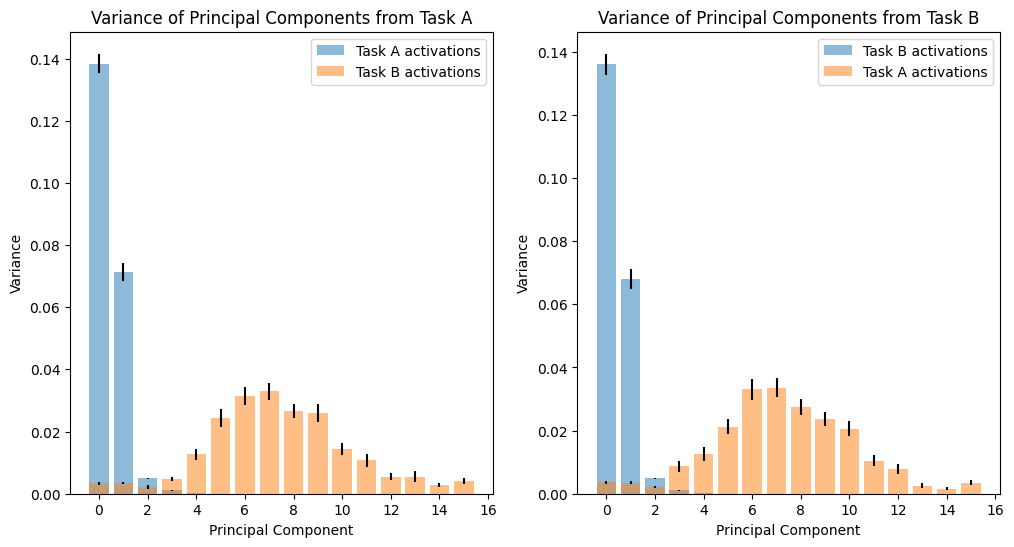

In [97]:
def plot_pca_variances(
    varAA,
    varAB,
    varBA,
    varBB,
    err_varAA=None,
    err_varAB=None,
    err_varBA=None,
    err_varBB=None,
):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # plot the variances for task A
    axs[0].bar(
        range(len(varAA)), varAA, yerr=err_varAA, label="Task A activations", alpha=0.5
    )
    axs[0].bar(
        range(len(varBA)), varAB, yerr=err_varAB, label="Task B activations", alpha=0.5
    )
    axs[0].set_xlabel("Principal Component")
    axs[0].set_ylabel("Variance")
    axs[0].set_title("Variance of Principal Components from Task A")
    axs[0].legend()

    # plot the variances for task B
    axs[1].bar(
        range(len(varAA)), varBB, yerr=err_varBB, label="Task B activations", alpha=0.5
    )
    axs[1].bar(
        range(len(varBA)), varBA, yerr=err_varBA, label="Task A activations", alpha=0.5
    )
    axs[1].set_xlabel("Principal Component")
    axs[1].set_ylabel("Variance")
    axs[1].set_title("Variance of Principal Components from Task B")
    axs[1].legend()

    plt.show()


plot_pca_variances(
    varAA,
    varAB,
    varBA,
    varBB,
    err_varAA=err_varAA,
    err_varAB=err_varAB,
    err_varBA=err_varBA,
    err_varBB=err_varBB,
)

This is much cleaner now:
- There's symmetry between the tasks (as expected)
- The variance for the alternative task is spread generally quite smoothly amongst the other components but I'd like to understand why it generally peaks around component 6 or 7. I suppose there's some geometric explanation and I suppose it's also dependent on the problem set up I have chosen.
- Confirmation that most of the task variance is contained within the first two principal components. I'm not sure if it's interesting that the second component explains roughly half the variance of the first. Got to be some power law business going on here.